In [ ]:
# 命名实体识别

# 安装包：pytorch
# pip install pytorch-crf


/Users/fubin/opt/anaconda3/lib/python3.9/site-packages/TorchCRF/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


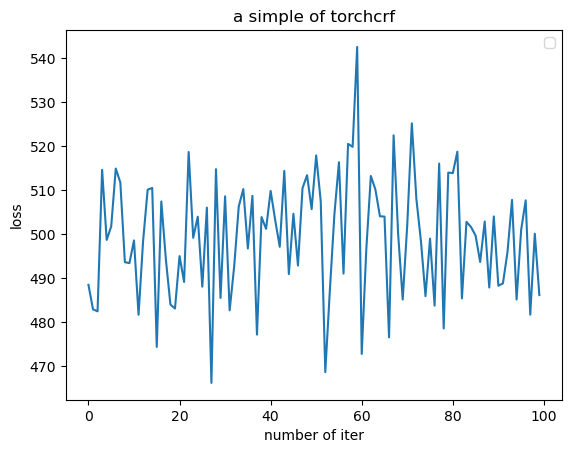

解码结果: [[1, 7, 7, 1, 0, 1, 6, 5, 6, 6, 2, 3, 4, 7, 1, 6, 5, 8, 3], [1, 2, 3, 1, 1, 4, 1, 6, 3, 5, 2, 4, 2, 6, 2, 3, 4, 7, 7], [5, 0, 5, 5, 4, 7, 4, 3, 1, 2, 1, 5, 0, 2, 3, 7, 7, 5, 3], [5, 1, 0, 6, 2, 5, 7, 1, 2, 1, 3, 0, 5, 8, 4, 4, 1, 6, 3]]


In [2]:
# 模型：
# 1.构建概率图模型：条件随机场CRF
import torch
from TorchCRF import CRF
from torch.utils.data import TensorDataset,DataLoader
from torch.optim import Adam

# 构建假数据
seq_len, num_tags = 19, 9
X = torch.randn(1000,seq_len,num_tags)
tags = torch.randint(0, num_tags, (1000, seq_len))
dataset = TensorDataset(X,tags)
batch_size = 10
dataloader = DataLoader(dataset, shuffle = True, batch_size = batch_size)
# 模型定义
model = CRF(num_tags = num_tags, batch_first = True)
optimizer = Adam(model.parameters(), lr = 0.05)
# 模型训练
losses = []
for seq, seq_tag in dataloader:
    optimizer.zero_grad()
    loss = (-1)*model(seq, seq_tag)
    loss.backward()
    optimizer.step()
    losses.append(loss.tolist())
# 可视化loss
import matplotlib.pyplot as plt
plt.xlabel('number of iter')
plt.ylabel('loss')
plt.title('a simple of torchcrf')
plt.plot(losses)
plt.legend()
plt.show()
print('解码结果:', model.decode(X[:4]))


In [4]:
# 模型：
# 2.构建概率图模型：BiLSTM + CRF 简单案例

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from TorchCRF import CRF
from torch.optim import Adam
import warnings
warnings.filterwarnings("ignore")

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.crf = CRF(num_tags = len(self.tag_to_ix), batch_first = True) # 很重要 batch_first = True
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # 简便折断
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, len(self.tag_to_ix))
    def __forward__(self, batch_token_ids): # [batch_size, seq_size]
        shape_ = batch_token_ids.shape
        embeds = self.word_embeds(batch_token_ids).view(shape_[0], shape_[1], self.embedding_dim)
        bilstm_out, _ = self.bilstm(embeds)
        bilstm_out = bilstm_out.view(shape_[0], shape_[1], self.hidden_dim)
        bilstm_feats = self.hidden2tag(bilstm_out)
        # print(bilstm_feats.shape) # orch.Size([10, 19, 4])
        return bilstm_feats
    def loss(self, batch_token_ids, tags, masks):
        feats = self.__forward__(batch_token_ids)
        return - self.crf(feats, tags, masks)
    def predict(self, batch_token_ids):
        feats = self.__forward__(batch_token_ids)
        return self.crf.decode(feats)

tag_to_ix = {'O':0, 'B': 1, 'I':2, 'E':3}
num_classes = len(tag_to_ix)
word_num = 100
seq_len = 19
embedding_dim = 64
hidden_dim = 32
model = BiLSTM_CRF(vocab_size = word_num, tag_to_ix = tag_to_ix, embedding_dim = embedding_dim, hidden_dim = hidden_dim)
# 构建假数据
all_token_ids = torch.randint(0, word_num, (99, seq_len)).long() # 词汇id, torch.Size([99, 19])
all_token_tags = torch.randint(0, len(tag_to_ix), (99, seq_len)).long() # tag 标注结果  torch.Size([99, 19])
all_token_masks = torch.ones_like(all_token_ids).bool() # mask  torch.Size([99, 19])
dataset = TensorDataset(all_token_ids, all_token_tags, all_token_masks)
batch_size = 10
dataloader = DataLoader(dataset, shuffle=True, batch_size = batch_size)
optimizer = Adam(model.parameters(), lr = 0.05)
# 模型训练
for seq, seq_tag, seq_mask in dataloader:
    optimizer.zero_grad()
    loss = model.loss(seq, seq_tag, seq_mask)
    loss.backward()
    optimizer.step()
    print('loss =', loss.item())
# 示例使用CRF进行序列标注
print(model.predict(all_token_ids[:3,:]))

loss = 267.31866455078125
loss = 264.75323486328125
loss = 272.2840576171875
loss = 271.5197448730469
loss = 266.4097900390625
loss = 270.8936462402344
loss = 264.8451843261719
loss = 274.60205078125
loss = 276.1224670410156
loss = 237.62351989746094
[[3, 0, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 3, 2, 3, 3, 1, 2, 3], [3, 2, 0, 3, 0, 0, 3, 0, 3, 1, 1, 1, 1, 1, 2, 0, 3, 0, 0], [1, 1, 1, 1, 1, 1, 2, 0, 0, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3]]


In [5]:
# BiLSTM_CRF：
# BiLSTM （word embedding或者bert embedding） + linear mapping（embedding_dim -> n_features or num_tags） + CRF (loss)

# 导入所需文件 spacy
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from TorchCRF import CRF
from torch.optim import Adam
import warnings
import numpy as np
from sklearn.model_selection import ShuffleSplit
from gensim.models import Word2Vec
from data.ruijinkg.data_utils.data_utils import ENTITIES, Documents, Dataset, SentenceExtractor, make_predictions
from data.ruijinkg.data_utils.evaluator import Evaluator
warnings.filterwarnings("ignore")

class BiLSTM_CRF(nn.Module):
    def __init__(self, num_cates, vocab_size, tag_to_ix, word_embeddings, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_cates = num_cates
        self.tag_to_ix = tag_to_ix
        self.crf = CRF(num_tags = num_cates, batch_first = True) # 很重要 batch_first = True
        self.word_embeds = nn.Embedding.from_pretrained(torch.from_numpy(word_embeddings))
        # 简便折断
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, num_cates)
    def __forward__(self, batch_token_ids): # [batch_size, seq_size]
        shape_ = batch_token_ids.shape
        # print(shape_, self.embedding_dim, self.word_embeds(batch_token_ids).shape)
        embeds = self.word_embeds(batch_token_ids).view(shape_[0], shape_[1], self.embedding_dim)
        bilstm_out, _ = self.bilstm(embeds)
        bilstm_out = bilstm_out.view(shape_[0], shape_[1], self.hidden_dim)
        bilstm_feats = self.hidden2tag(bilstm_out)
        # print(bilstm_feats.shape) # orch.Size([10, 19, 4])
        return bilstm_feats
    def loss(self, batch_token_ids, tags, masks):
        feats = self.__forward__(batch_token_ids)
        # print(feats.shape, tags.shape, masks.shape)
        return - self.crf(feats, tags, masks)
    def predict(self, batch_token_ids):
        feats = self.__forward__(batch_token_ids)
        return self.crf.decode(feats)

# 数据文件读取
data_dir = "./data/ruijinkg/data/train"
ent2idx = dict(zip(ENTITIES, range(1, len(ENTITIES) + 1)))
idx2ent = dict([(v, k) for k, v in ent2idx.items()])

# 训练集，测试集切分与打乱
docs = Documents(data_dir=data_dir)
rs = ShuffleSplit(n_splits=1, test_size=20, random_state=2018)
train_doc_ids, test_doc_ids = next(rs.split(docs))
train_docs, test_docs = docs[train_doc_ids], docs[test_doc_ids]
# 模型参数赋值
num_cates = max(ent2idx.values()) + 1
sent_len = 64
vocab_size = 3000
emb_size = 100
sent_pad = 10
sent_extrator = SentenceExtractor(window_size=sent_len, pad_size=sent_pad)
train_sents = sent_extrator(train_docs)
test_sents = sent_extrator(test_docs)
train_data = Dataset(train_sents, cate2idx=ent2idx)
train_data.build_vocab_dict(vocab_size=vocab_size)
test_data = Dataset(test_sents, word2idx=train_data.word2idx, cate2idx=ent2idx)
vocab_size = len(train_data.word2idx)
# 词嵌入模型构建
w2v_train_sents = []
for doc in docs:
    w2v_train_sents.append(list(doc.text))
w2v_model = Word2Vec(w2v_train_sents, vector_size=emb_size)
w2v_embeddings = np.zeros((vocab_size, emb_size))
for char, char_idx in train_data.word2idx.items():
    if char in w2v_model.wv:
        w2v_embeddings[char_idx] = w2v_model.wv[char]

# CRF条件随机场实例化
print(w2v_embeddings.shape)
model = BiLSTM_CRF(vocab_size = vocab_size, num_cates = num_cates, tag_to_ix = ent2idx, word_embeddings = w2v_embeddings.astype(np.float32), embedding_dim = emb_size, hidden_dim = 64)

# 训练集，测试集形状
batch_size = 10
dataloader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
# 模型定义
optimizer = Adam(model.parameters(), lr = 0.05)
# 模型训练
for seq, seq_tag in dataloader:
    optimizer.zero_grad()
    seq_mask = torch.ones_like(seq)
    seq, seq_tag, seq_mask = seq.squeeze().long(), seq_tag.squeeze().long(), seq_mask.squeeze().bool()
    # print(seq.shape, seq_tag.shape, seq_mask.shape)
    loss = model.loss(seq, seq_tag, seq_mask)
    loss.backward()
    optimizer.step()
    print('loss =', loss.item())



(2154, 100)
loss = 2274.661865234375
loss = 1412.525634765625
loss = 871.842529296875
loss = 635.783203125
loss = 479.56591796875
loss = 796.300048828125
loss = 616.8015747070312
loss = 751.3322143554688
loss = 618.5487060546875
loss = 695.362060546875
loss = 629.3770751953125
loss = 562.5451049804688
loss = 333.31103515625
loss = 398.85638427734375
loss = 727.3421630859375
loss = 459.9878845214844
loss = 535.0306396484375
loss = 494.2618408203125
loss = 420.13043212890625
loss = 540.7581176757812
loss = 360.2719421386719
loss = 368.5841369628906
loss = 433.14117431640625
loss = 447.36785888671875
loss = 326.5769958496094
loss = 502.8112487792969
loss = 517.9593505859375
loss = 434.51568603515625
loss = 373.7227783203125
loss = 330.0563049316406
loss = 340.66827392578125
loss = 265.15869140625
loss = 403.1212158203125
loss = 300.79803466796875
loss = 328.957763671875
loss = 258.57855224609375
loss = 493.8677062988281
loss = 270.4941711425781
loss = 240.83013916015625
loss = 338.2187805

In [26]:
# Bert + CasRel （已测试）

# bert cls位置enbedding -> mlp（1层）->预测头尾实体和关系
# p(head,tail,relation | x) = p(head | x) * p(tail | head, x) * p(relation | head,tail,x)
# p(head), p(tail), p(head-tail: relation)

# 4个loss： subject_type_loss, object_type_loss, subject_relation_loss, object_relation_loss:
# # 根据就近原则，关系矩阵可以拆分两个向量
# sub_heads, sub_tails = torch.zeros(text_len), torch.zeros(text_len)
# sub_head, sub_tail = torch.zeros(text_len), torch.zeros(text_len)
# obj_heads = torch.zeros((text_len, num_rel))
# obj_tails = torch.zeros((text_len, num_rel))

# entity embedding = ave (all token embeddings)

# utf-8

import torch, os
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel
import json
from random import choice
from fastNLP import Vocabulary, Callback
from torch.utils.data import DataLoader, Dataset
from fastNLP.io import JsonLoader
import numpy as np
from transformers import BertTokenizer
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_rel = 18
bert_dim = 768
max_seq_len = 300
train_path = 'data/baidu/train.json'
test_path = 'data/baidu/test_.json'
dev_path = 'data/baidu/dev.json'
rel_path = 'data/baidu/rel.json'
save_weights_fpath = '/models/baidu/model.pt'
save_logs_fpath = '/models/baidu/model.out'
result_fpath = '/models/baidu/result.json'
bert_dirpath = './models/roberta-base-finetuned-dianping-chinese'
batch_size = 8
lr = 1e-5
max_epoch = 10

class CasRel(nn.Module):
    def __init__(self, bert_dirpath, bert_dim, num_relations):
        super(CasRel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_dirpath)
        self.sub_heads_linear = nn.Linear(bert_dim, 1)
        self.sub_tails_linear = nn.Linear(bert_dim, 1)
        self.obj_heads_linear = nn.Linear(bert_dim, num_relations)
        self.obj_tails_linear = nn.Linear(bert_dim, num_relations)
    def __get_encoded_text__(self, token_ids, mask):
        # print(token_ids.shape, mask.shape) # torch.Size([1, 20]) torch.Size([1, 20])
        # print(self.bert(token_ids, attention_mask=mask)[0].shape) # torch.Size([1, 20, 768])
        return self.bert(token_ids, attention_mask=mask)[0] # 获取句子中所有word的embedding
    def __get_subs__(self, encoded_text):
        pred_sub_heads = torch.sigmoid(self.sub_heads_linear(encoded_text))
        pred_sub_tails = torch.sigmoid(self.sub_tails_linear(encoded_text))
        return pred_sub_heads, pred_sub_tails
    def __get_objs_for_specific_sub__(self, sub_head_mapping, sub_tail_mapping, encoded_text): # 1
        # sub_head_mapping [batch, 1, seq] * encoded_text [batch, seq, dim]
        sub_head = torch.matmul(sub_head_mapping, encoded_text)
        sub_tail = torch.matmul(sub_tail_mapping, encoded_text)
        sub = (sub_head + sub_tail) / 2
        encoded_text = encoded_text + sub
        pred_obj_heads = torch.sigmoid(self.obj_heads_linear(encoded_text))
        pred_obj_tails = torch.sigmoid(self.obj_tails_linear(encoded_text))
        return pred_obj_heads, pred_obj_tails
    def forward(self, token_ids, mask, sub_head, sub_tail): # 2
        # 1.获取序列中所有茨嵌入
        encoded_text = self.__get_encoded_text__(token_ids, mask) # torch.Size([1, 20, 768])
        # 2.预测头和尾实体
        pred_sub_heads, pred_sub_tails = self.__get_subs__(encoded_text) # torch.Size([1, 20, 1]) torch.Size([1, 20, 1])
        sub_head_mapping = sub_head.unsqueeze(1)
        sub_tail_mapping = sub_tail.unsqueeze(1)
        # 3.交叉，根据头实体预测尾实体
        pred_obj_heads, pre_obj_tails = self.__get_objs_for_specific_sub__(sub_head_mapping, sub_tail_mapping, encoded_text)
        return {"sub_heads": pred_sub_heads, "sub_tails": pred_sub_tails, "obj_heads": pred_obj_heads, "obj_tails": pre_obj_tails,}

def load_data(train_path, dev_path, test_path, rel_dict_path):
    paths = {'train': train_path, 'dev': dev_path, 'test': test_path}
    loader = JsonLoader({"text": "text", "spo_list": "spo_list"})
    data_bundle = loader.load(paths)
    id2rel = json.load(open(rel_dict_path, encoding='utf-8'))
    rel_vocab = Vocabulary(unknown=None, padding=None)
    rel_vocab.add_word_lst(list(id2rel.values()))
    return data_bundle, rel_vocab

data_bundle, rel_vocab = load_data(train_path, dev_path, test_path, rel_path)
print(type(data_bundle), type(rel_vocab))

def find_head_idx(source, target):
    target_len = len(target)
    for i in range(len(source)):
        if source[i: i + target_len] == target:
            return i
    return -1
class MyDataset(Dataset):
    def __init__(self, bert_dirpath, dataset, rel_vocab, max_seq_len, is_test):
        super().__init__()
        self.dataset = dataset
        self.rel_vocab = rel_vocab
        self.is_test = is_test
        self.max_seq_len = max_seq_len
        self.tokenizer = BertTokenizer.from_pretrained(bert_dirpath)
    def __getitem__(self, item):
        json_data = self.dataset[item]
        text = json_data['text']
        tokenized = self.tokenizer(text, max_length= self.max_seq_len, truncation=True)
        tokens = tokenized['input_ids']
        masks = tokenized['attention_mask']
        text_len = len(tokens)
        token_ids = torch.tensor(tokens, dtype=torch.long)
        masks = torch.tensor(masks, dtype=torch.bool)
        sub_heads, sub_tails = torch.zeros(text_len), torch.zeros(text_len)
        sub_head, sub_tail = torch.zeros(text_len), torch.zeros(text_len)
        # 根据就近原则，关系矩阵可以拆分两个向量
        obj_heads = torch.zeros((text_len, num_rel))
        obj_tails = torch.zeros((text_len, num_rel))
        if not self.is_test:
            s2ro_map = defaultdict(list)
            for spo in json_data['spo_list']:
                triple = (self.tokenizer(spo['subject'], add_special_tokens=False)['input_ids'], self.rel_vocab.to_index(spo['predicate']), self.tokenizer(spo['object'], add_special_tokens=False)['input_ids'])
                sub_head_idx = find_head_idx(tokens, triple[0])
                obj_head_idx = find_head_idx(tokens, triple[2])
                if sub_head_idx != -1 and obj_head_idx != -1:
                    sub = (sub_head_idx, sub_head_idx + len(triple[0]) - 1)
                    s2ro_map[sub].append( (obj_head_idx, obj_head_idx + len(triple[2]) - 1, triple[1]))
            if s2ro_map:
                for s in s2ro_map:
                    sub_heads[s[0]] = 1
                    sub_tails[s[1]] = 1
                sub_head_idx, sub_tail_idx = choice(list(s2ro_map.keys()))
                sub_head[sub_head_idx] = 1
                sub_tail[sub_tail_idx] = 1
                for ro in s2ro_map.get((sub_head_idx, sub_tail_idx), []):
                    obj_heads[ro[0]][ro[2]] = 1
                    obj_tails[ro[1]][ro[2]] = 1
        return token_ids, masks, sub_heads, sub_tails, sub_head, sub_tail, obj_heads, obj_tails, json_data['spo_list']
    def __len__(self):
        return len(self.dataset)
def my_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    token_ids, masks, sub_heads, sub_tails, sub_head, sub_tail, obj_heads, obj_tails, triples = zip(*batch)
    batch_token_ids = pad_sequence(token_ids, batch_first=True)
    batch_masks = pad_sequence(masks, batch_first=True)
    batch_sub_heads = pad_sequence(sub_heads, batch_first=True)
    batch_sub_tails = pad_sequence(sub_tails, batch_first=True)
    batch_sub_head = pad_sequence(sub_head, batch_first=True)
    batch_sub_tail = pad_sequence(sub_tail, batch_first=True)
    batch_obj_heads = pad_sequence(obj_heads, batch_first=True)
    batch_obj_tails = pad_sequence(obj_tails, batch_first=True)
    return {"token_ids": batch_token_ids.to(device), "mask": batch_masks.to(device), "sub_head": batch_sub_head.to(device),
            "sub_tail": batch_sub_tail.to(device), "sub_heads": batch_sub_heads.to(device), }, \
           {"mask": batch_masks.to(device), "sub_heads": batch_sub_heads.to(device), "sub_tails": batch_sub_tails.to(device),
            "obj_heads": batch_obj_heads.to(device), "obj_tails": batch_obj_tails.to(device), "triples": triples}
def get_data_iterator(bert_dirpath, dataset, rel_vocab, max_seq_len, batch_size, is_test=False, collate_fn=my_collate_fn):
    dataset = MyDataset(bert_dirpath, dataset, rel_vocab, max_seq_len, is_test)
    return DataLoader(dataset=dataset, collate_fn=collate_fn, batch_size=batch_size if not is_test else 1)

train_data = get_data_iterator(bert_dirpath, data_bundle.get_dataset('train'), rel_vocab, max_seq_len, batch_size, False, my_collate_fn)
dev_data = get_data_iterator(bert_dirpath, data_bundle.get_dataset('dev'), rel_vocab, max_seq_len, batch_size, True, my_collate_fn)
test_data = get_data_iterator(bert_dirpath, data_bundle.get_dataset('test'), rel_vocab, max_seq_len, batch_size, True, my_collate_fn)
print(len(train_data), len(dev_data), len(test_data))

model = CasRel(bert_dirpath, bert_dim, num_rel)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr= lr)

def to_tuple(triple_list):
    ret = []
    for triple in triple_list:
        ret.append((triple['subject'], triple['predicate'], triple['object']))
    return ret
def metric(data_iter, rel_vocab, bert_dirpath, model, result_fpath, output=True, h_bar=0.5, t_bar=0.5):
    orders = ['subject', 'relation', 'object']
    correct_num, predict_num, gold_num = 0, 0, 0
    tokenizer = BertTokenizer.from_pretrained(bert_dirpath)
    for batch_x, batch_y in tqdm(data_iter):
        with torch.no_grad():
            token_ids = batch_x['token_ids']
            mask = batch_x['mask']
            encoded_text = model.__get_encoded_text__(token_ids, mask)
            pred_sub_heads, pred_sub_tails = model.__get_subs__(encoded_text)
            sub_heads = torch.where(pred_sub_heads[0] > h_bar)[0]
            sub_tails = torch.where(pred_sub_tails[0] > t_bar)[0]
            subjects = []
            for sub_head in sub_heads:
                sub_tail = sub_tails[sub_tails >= sub_head]
                if len(sub_tail) > 0:
                    sub_tail = sub_tail[0]
                    subject = ''.join(tokenizer.decode(token_ids[0][sub_head: sub_tail + 1]).split())
                    subjects.append((subject, sub_head, sub_tail))
            if subjects:
                triple_list = []
                repeated_encoded_text = encoded_text.repeat(len(subjects), 1, 1)
                sub_head_mapping = torch.zeros((len(subjects), 1, encoded_text.size(1)), dtype=torch.float, device=device)
                sub_tail_mapping = torch.zeros((len(subjects), 1, encoded_text.size(1)), dtype=torch.float,  device=device)
                for subject_idx, subject in enumerate(subjects):
                    sub_head_mapping[subject_idx][0][subject[1]] = 1
                    sub_tail_mapping[subject_idx][0][subject[2]] = 1
                pred_obj_heads, pred_obj_tails = model.__get_objs_for_specific_sub__(sub_head_mapping, sub_tail_mapping, repeated_encoded_text)
                for subject_idx, subject in enumerate(subjects):
                    sub = subject[0]
                    obj_heads = torch.where(pred_obj_heads[subject_idx] > h_bar)
                    obj_tails = torch.where(pred_obj_tails[subject_idx] > t_bar)
                    for obj_head, rel_head in zip(*obj_heads):
                        for obj_tail, rel_tail in zip(*obj_tails):
                            if obj_head <= obj_tail and rel_head == rel_tail:
                                rel = rel_vocab.to_word(int(rel_head))
                                obj = ''.join(tokenizer.decode(token_ids[0][obj_head: obj_tail + 1]).split())
                                triple_list.append((sub, rel, obj))
                                break
                triple_set = set()
                for s, r, o in triple_list:
                    triple_set.add((s, r, o))
                pred_list = list(triple_set)
            else:
                pred_list = []
            pred_triples = set(pred_list)
            gold_triples = set(to_tuple(batch_y['triples'][0]))
            correct_num += len(pred_triples & gold_triples)
            predict_num += len(pred_triples)
            gold_num += len(gold_triples)
            if output:
                result_dir = '/'.join(result_fpath.split('/')[:-1])
                if not os.path.exists(result_dir):
                    os.mkdir(result_dir)
                fw = open(result_fpath, 'w')
                result = json.dumps({ 'triple_list_gold': [dict(zip(orders, triple)) for triple in gold_triples],
                    'triple_list_pred': [dict(zip(orders, triple)) for triple in pred_triples],
                    'new': [dict(zip(orders, triple)) for triple in pred_triples - gold_triples],
                    'lack': [dict(zip(orders, triple)) for triple in gold_triples - pred_triples]}, ensure_ascii=False)
                fw.write(result + '\n')
    print("correct_num: {:3d}, predict_num: {:3d}, gold_num: {:3d}".format(correct_num, predict_num, gold_num))
    precision = correct_num / (predict_num + 1e-10)
    recall = correct_num / (gold_num + 1e-10)
    f1_score = 2 * precision * recall / (precision + recall + 1e-10)
    print('f1: {:4.2f}, precision: {:4.2f}, recall: {:4.2f}'.format(f1_score, precision, recall))
    return precision, recall, f1_score
class MyCallBack(Callback):
    def __init__(self, data_iter, rel_vocab, save_logs_fpath, bert_dirpath, result_fpath, weight_fpath):
        super().__init__()
        self.best_epoch = 0
        self.best_recall = 0
        self.best_precision = 0
        self.best_f1_score = 0
        self.data_iter = data_iter
        self.rel_vocab = rel_vocab
        self.save_logs_fpath = save_logs_fpath
        self.bert_dirpath = bert_dirpath
        self.result_fpath = result_fpath
        self.weight_fpath = weight_fpath
    def logging(self, s, print_=True, log_=False):
        if print_:
            print(s)
        if log_:
            with open(save_logs_fpath, 'a+') as f_log:
                f_log.write(s + '\n')
    def on_train_begin(self):
        self.logging("-" * 5 + "Begin Training" + "-" * 5)
    def on_epoch_end(self):
        precision, recall, f1_score = metric(self.data_iter, self.rel_vocab, self.bert_dirpath, self.model, self.result_fpath)
        self.logging('epoch {:3d}, f1: {:4.2f}, precision: {:4.2f}, recall: {:4.2f}'.format(self.epoch, f1_score, precision, recall))
        if f1_score > self.best_f1_score:
            self.best_f1_score = f1_score
            self.best_epoch = self.epoch
            self.best_precision = precision
            self.best_recall = recall
            self.logging("Saving the model, epoch: {:3d}, best f1: {:4.2f}, precision: {:4.2f}, recall: {:4.2f}".format(self.best_epoch, self.best_f1_score, precision, recall))
            torch.save(self.model.state_dict(), self.weight_fpath)
    def on_train_end(self):
        self.logging("-" * 5 + "Finish training" + "-" * 5)
        self.logging("best epoch: {:3d}, best f1: {:4.2f}, precision: {:4.2f}, recall: {:4.2}".format(self.best_epoch, self.best_f1_score, self.best_precision, self.best_recall))
from fastNLP import Trainer
class MyLoss:
    def __init__(self):
        super(MyLoss, self).__init__()
    def get_loss(self, predict, target):
        mask = target['mask']
        def loss_fn(pred, gold, mask):
            pred = pred.squeeze(-1)
            loss = torch.nn.BCELoss(pred, gold, reduction='none')
            if loss.shape != mask.shape:
                mask = mask.unsqueeze(-1)
            loss = torch.sum(loss * mask) / torch.sum(mask)
            return loss
        return loss_fn(predict['sub_heads'], target['sub_heads'], mask) + \
               loss_fn(predict['sub_tails'], target['sub_tails'], mask) + \
               loss_fn(predict['obj_heads'], target['obj_heads'], mask) + \
               loss_fn(predict['obj_tails'], target['obj_tails'], mask)
    def __call__(self, pred_dict, target_dict, check=False):
        loss = self.get_loss(pred_dict, target_dict)
        return loss

period = 200
trainer = Trainer(train_dataloader=train_data, model=model, optimizers=[optimizer], batch_size=batch_size,
                  n_epochs=max_epoch, loss=MyLoss(), print_every=period, use_tqdm=True,
                  callbacks=MyCallBack(dev_data, rel_vocab, save_logs_fpath, bert_dirpath, result_fpath, save_weights_fpath))
# trainer.run(1)
trainer.step()
print("-" * 5 + "Begin Testing" + "-" * 5)
metric(test_data, rel_vocab, bert_dirpath, model, result_fpath, output=False)


<class 'fastNLP.io.data_bundle.DataBundle'> <class 'fastNLP.core.vocabulary.Vocabulary'>
6995 11191 10
-----Begin Testing-----


100%|██████████| 10/10 [06:37<00:00, 39.76s/it]

correct_num:   0, predict_num: 38047, gold_num:  22
f1: 0.00, precision: 0.00, recall: 0.00


(0.0, 0.0, 0.0)

In [30]:
# py2neo 入库操作
# 还可以执行cypher命令,如搜索二阶邻居节点关系等

# utf-8

# 1.安装jdk和配置环境变量
# 2.配置neo4j和配置环境变量

import json

train_path = 'data/baidu/train.json'
head_tail_relation = []
with open(train_path, 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')
    for line in lines:
        for t in json.loads(line)['spo_list']:
            head_type, tail_type = t['subject_type'], t['object_type']
            head, tail, relation = t['subject'], t['object'], t['predicate']
            head_tail_relation.append((head_type, head, tail_type, tail, relation))
print(head_tail_relation[:10])

# python操作neo4j
# pip install py2neo

from py2neo import Graph, Node, Relationship, NodeMatcher, RelationshipMatcher, Subgraph
# 建立连接
graph = Graph('http://localhost:7474/', auth=("neo4j", "admin"))
# 删除所有
graph.delete_all()
# 定义节点
a = Node('人物', name='木斧')
b = Node('日期', name='1931')
# 节点匹配
node_matcher = NodeMatcher(graph)
nodea = node_matcher.match('人物', name='木斧').first()
nodeb = node_matcher.match('日期', name='1931').first()
# 关系匹配
relationship_matcher = RelationshipMatcher(graph)
relations = relationship_matcher.match(nodes=[nodea, nodeb]).all()
# 删除关系链(若关系为空则删除节点)
if relations:
    print(relations[0])
    graph.delete(relations[0])
# 创建关系和节点
ab = Relationship(a, '出生日期', b)
graph.create(ab)
# 查找所有节点
all_nodes = graph.nodes.match().all()
print('查找所有节点:', all_nodes)
# 匹配指定条件的节点
nodes = node_matcher.match('人物', name='木斧').all()
node1 = node_matcher.match('人物', name='木斧').first()
print('匹配指定条件的节点:', nodes, node1)
# 修改节点
node1['name'] = 'fubin'
subgraph = Subgraph(nodes = [node1]) # 子图对象
graph.push(subgraph)
print('修改节点:', graph.nodes.match().all())
# 新增关系
nodea = node_matcher.match('人物', name='fubin').first()
nodeb = node_matcher.match('日期', name='1931').first()
relationship = Relationship(nodea, '诞生于', nodeb)
graph.create(relationship)
print('新增关系:', graph.nodes.match().all(), graph.relationships.match().all())
# 删除关系（不删除节点）
relations = relationship_matcher.match(nodes=[nodea, nodeb]).all()
graph.separate(relations[0])
print('删除关系（不删除节点）:', relations[0], '->', graph.relationships.match().all())

# 批量导入命令
# neo4j-admin import --database kg_name --nodes=人物=人物.csv --nodes=城市=城市.csv  --nodes=日期=日期.csv  --relationships=出生地=出生地.csv  --relationships=出生日期=出生日期.csv --trim-strings=true

[('人物', '木斧', '文本', '回族', '民族'), ('人物', '木斧', '日期', '1931', '出生日期'), ('人物', '木斧', '地点', '成都', '出生地'), ('歌曲', '今晚会在哪里醒来', '人物', '黄家强', '作曲'), ('歌曲', '今晚会在哪里醒来', '音乐专辑', '她他', '所属专辑'), ('歌曲', '今晚会在哪里醒来', '人物', '黄家强', '歌手'), ('歌曲', '今晚会在哪里醒来', '人物', '何启弘', '作词'), ('企业', '华夏建通科技开发股份有限公司', '日期', '2004年6月3日', '成立日期'), ('人物', '潘惟南', '地点', '陕西大荔', '出生地'), ('人物', '郭静唐', '地点', '周巷', '出生地')]
查找所有节点: [Node('人物', name='木斧'), Node('日期', name='1931')]
匹配指定条件的节点: [Node('人物', name='木斧')] (_26:人物 {name: '\u6728\u65a7'})
修改节点: [Node('人物', name='fubin'), Node('日期', name='1931')]
新增关系: [Node('人物', name='fubin'), Node('日期', name='1931')] [诞生于(Node('人物', name='fubin'), Node('日期', name='1931')), 出生日期(Node('人物', name='fubin'), Node('日期', name='1931'))]
删除关系（不删除节点）: (fubin)-[:诞生于 {}]->(1931) -> [出生日期(Node('人物', name='fubin'), Node('日期', name='1931'))]


In [ ]:
# kg表示学习推理
# TransE

import numpy as np
import json
import torch
import torch.nn as nn
from torch.autograd import Variable
def norm_l1(h, r, t):
    return np.sum(np.fabs(h + r - t))
def norm_l2(h, r, t):
    return np.sum(np.square(h + r - t))
class TransE(nn.Module):
    def __init__(self, entity_num, relation_num, dim, margin, norm, C):
        super(TransE, self).__init__()
        self.entity_num = entity_num
        self.relation_num = relation_num
        self.dim = dim
        self.margin = margin
        self.norm = norm
        self.C = C
        self.ent_embedding = torch.nn.Embedding(num_embeddings=self.entity_num, embedding_dim=self.dim)
        self.rel_embedding = torch.nn.Embedding(num_embeddings=self.relation_num, embedding_dim=self.dim)
        nn.init.xavier_uniform_(self.ent_embedding.weight.data)
        self.normalization_ent_embedding()
        nn.init.xavier_uniform_(self.rel_embedding.weight.data)
        self.normalization_rel_embedding()
        self.loss_F = nn.MarginRankingLoss(self.margin, reduction="mean")
    def normalization_ent_embedding(self):
        norm = self.ent_embedding.weight.detach().cpu().numpy()
        norm = norm / np.sqrt(np.sum(np.square(norm), axis=1, keepdims=True))
        self.ent_embedding.weight.data.copy_(torch.from_numpy(norm))
    def normalization_rel_embedding(self):
        norm = self.rel_embedding.weight.detach().cpu().numpy()
        norm = norm / np.sqrt(np.sum(np.square(norm), axis=1, keepdims=True))
        self.rel_embedding.weight.data.copy_(torch.from_numpy(norm))
    def input_pre_transe(self, ent_vector, rel_vector):
        for i in range(self.entity_num):
            self.ent_embedding.weight.data[i] = torch.from_numpy(np.array(ent_vector[i]))
        for i in range(self.relation_num):
            self.rel_embedding.weight.data[i] = torch.from_numpy(np.array(rel_vector[i]))
    def distance(self, h, r, t):
        head = self.ent_embedding(h)
        rel = self.rel_embedding(r)
        tail = self.ent_embedding(t)
        distance = head + rel - tail
        # dim = -1表示的是维度的最后一维 比如如果一个张量有3维 那么 dim = 2 = -1， dim = 0 = -3
        score = torch.norm(distance, p = self.norm, dim=1)
        return score
    def scale_loss(self, embedding):
        return torch.sum(torch.max(torch.sum(embedding ** 2, dim=1, keepdim=True)-torch.autograd.Variable(torch.FloatTensor([1.0])), torch.autograd.Variable(torch.FloatTensor([0.0]))))
    def forward(self, current_triples, corrupted_triples):
        h, r, t = torch.chunk(current_triples, 3, dim=1)
        h_c, r_c, t_c = torch.chunk(corrupted_triples, 3, dim=1)
        h = torch.squeeze(h, dim=1)
        r = torch.squeeze(r, dim=1)
        t = torch.squeeze(t, dim=1)
        h_c = torch.squeeze(h_c, dim=1)
        r_c = torch.squeeze(r_c, dim=1)
        t_c = torch.squeeze(t_c, dim=1)
        pos = self.distance(h, r, t)
        neg = self.distance(h_c, r_c, t_c)
        entity_embedding = self.ent_embedding(torch.cat([h, t, h_c, t_c]).cuda())
        relation_embedding = self.rel_embedding(torch.cat([r, r_c]).cuda())
        y = Variable(torch.Tensor([-1])).cuda()
        loss = self.loss_F(pos, neg, y)
        ent_scale_loss = self.scale_loss(entity_embedding)
        rel_scale_loss = self.scale_loss(relation_embedding)
        return loss + self.C * (ent_scale_loss/len(entity_embedding) + rel_scale_loss/len(relation_embedding))


In [ ]:
# kg应用：知识问答

# 1.基于信息抽取的知识问答（适合于简单问题，解释好）
# 思路：实体链接 -> 2跳节点（生成候选答案） -> 构造特征训练模型或者规则

# 2.基于路径推理的知识问答（适合稍微复杂一些的推理问题，解释较好）
# 思路：利用强化学习来找答案的推理路径模型，本质类似sql执行路径

# 3.基于kg嵌入的知识问答（适合复杂推理问题，解释差）
# 思路：知识图谱嵌入表示（如transE） -> 得到查询节点的上下文信息 作为新特征加入到问答匹配模型中


In [ ]:
# kg应用：文本生成

# 1.常识驱动的对话系统、故事生成
# （每个实体单词）检索子图 -> 图注意力融合 -> 选择合适实体输出



In [ ]:
# kg应用：情感分类和情感抽取

# 情感词+句子上下文+知识图谱

In [ ]:
# kg应用：基于知识图谱可解释的推荐系统
